In [5]:
#Installation
!pip install dnspython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 7.2 MB/s eta 0:00:00a 0:00:01


In [ ]:
# Cell 1: Setup and Imports
import pymongo
from pymongo import MongoClient
import pandas as pd
from datetime import datetime
import re
from tqdm import tqdm
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from collections import Counter
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
import os
from dotenv import load_dotenv

# Cell 2: MongoDB Connection and Data Validation
# Connect to MongoDB
# Load environment variables from the .env file in 3_app_system/backend/
env_path = os.path.join('3_app_system', 'backend', '.env')
if not os.path.isfile(env_path):
    raise FileNotFoundError(f".env file not found at {env_path}. Please check the path.")
load_dotenv(dotenv_path=env_path)

mongo_uri = os.getenv('MONGODB_URI')
if not mongo_uri:
    raise ValueError("MONGODB_URI not found in .env file at 3_app_system/backend/.env")

client = MongoClient(mongo_uri)
db = client['MyParliament']
collection = db['HansardDocument'] 

# Validate connection and get document count
try:
    total_docs = collection.count_documents({})
    logger.info(f"Connected to MongoDB. Total documents: {total_docs:,}")
    
    # Check required fields exist
    sample_doc = collection.find_one({})
    required_fields = ['content_text', 'hansardDate']
    missing_fields = [field for field in required_fields if field not in sample_doc]
    
    if missing_fields:
        raise ValueError(f"Missing required fields: {missing_fields}")
    
    print(f"MongoDB connection successful")
    print(f"Found {total_docs:,} documents")
    print(f"Required fields validated")
    
except Exception as e:
    logger.error(f"MongoDB connection failed: {e}")
    raise

# Check current flagging status
flagged_count = collection.count_documents({
    "scrapMethod": {"$exists": True},
    "docLength": {"$exists": True}, 
    "decade": {"$exists": True}
})

print(f"Already flagged: {flagged_count:,} documents")
print(f"Remaining to flag: {total_docs - flagged_count:,} documents")

2025-06-04 16:47:59,865 - INFO - Connected to MongoDB. Total documents: 3,816


MongoDB connection successful
Found 3,816 documents
Required fields validated
Already flagged: 0 documents
Remaining to flag: 3,816 documents


In [10]:
# Cell 3: Helper Functions for Flagging Logic
def determine_scrap_method(doc):
    """
    Determine scraping method based on document fields
    """
    # pdfplumber condition: ocr_text field doesn't exist
    if 'ocr_text' not in doc:
        return 'pdfplumber'
    
    # googlevision: ocr_text exists AND low_ocr_resol = "solved"
    elif 'ocr_text' in doc and doc.get('low_ocr_resol') == 'solved':
        return 'googlevision'
    
    # tesseract: ocr_text exists but low_ocr_resol != "solved" (or doesn't exist)
    elif 'ocr_text' in doc and doc.get('low_ocr_resol') != 'solved':
        return 'tesseract'
    
    # Fallback for edge cases
    else:
        logger.warning(f"Could not determine scrap method for doc {doc.get('_id')}")
        return 'unknown'

def count_words(text):
    """
    Count words in text content
    """
    if not text or not isinstance(text, str):
        return 0
    
    # Remove extra whitespace and split on whitespace
    words = re.findall(r'\b\w+\b', text.lower())
    return len(words)

def categorize_doc_length(word_count):
    """
    Categorize document length based on word count
    Short: <2,000 words
    Medium: 2,000-10,000 words  
    Long: >10,000 words
    """
    if word_count < 2000:
        return 'short'
    elif word_count <= 10000:
        return 'medium'
    else:
        return 'long'

def extract_decade(hansard_date):
    """
    Extract decade from hansardDate
    """
    try:
        if isinstance(hansard_date, str):
            # Parse string date
            date_obj = datetime.strptime(hansard_date[:10], '%Y-%m-%d')
        else:
            # Already datetime object
            date_obj = hansard_date
            
        year = date_obj.year
        decade_start = (year // 10) * 10
        return f"{decade_start}s"
    
    except Exception as e:
        logger.warning(f"Could not parse date {hansard_date}: {e}")
        return 'unknown'

# Test helper functions
print("Testing helper functions...")
test_doc = {
    'content_text': 'This is a test document with some words for testing.',
    'hansardDate': '2023-05-15'
}

test_word_count = count_words(test_doc['content_text'])
test_length_cat = categorize_doc_length(test_word_count)
test_decade = extract_decade(test_doc['hansardDate'])

print(f"Word count: {test_word_count}")
print(f"Length category: {test_length_cat}")  
print(f"Decade: {test_decade}")

Testing helper functions...
Word count: 10
Length category: short
Decade: 2020s


In [11]:
# Cell 4: Batch Processing Function with Multithreading
def process_document_batch(doc_batch):
    """
    Process a batch of documents and return update operations
    """
    thread_id = threading.current_thread().ident
    batch_updates = []
    
    for doc in doc_batch:
        try:
            # Skip if already flagged
            if all(field in doc for field in ['scrapMethod', 'docLength', 'decade']):
                continue
                
            doc_id = doc['_id']
            
            # Determine scrap method
            scrap_method = determine_scrap_method(doc)
            
            # Count words and categorize length
            word_count = count_words(doc.get('content_text', ''))
            doc_length = categorize_doc_length(word_count)
            
            # Extract decade
            decade = extract_decade(doc.get('hansardDate'))
            
            # Prepare update operation
            update_op = {
                'filter': {'_id': doc_id},
                'update': {
                    '$set': {
                        'scrapMethod': scrap_method,
                        'docLength': doc_length,
                        'decade': decade,
                        'wordCount': word_count,
                        'flagged_timestamp': datetime.now()
                    }
                }
            }
            
            batch_updates.append(update_op)
            
        except Exception as e:
            logger.error(f"Error processing document {doc.get('_id')}: {e}")
            continue
    
    logger.info(f"Thread {thread_id}: Processed {len(batch_updates)} documents")
    return batch_updates

def execute_batch_updates(update_batch):
    """
    Execute batch updates to MongoDB
    """
    if not update_batch:
        return 0
        
    try:
        # Use bulk_write for efficient updates
        operations = [
            pymongo.UpdateOne(update['filter'], update['update'])
            for update in update_batch
        ]
        
        result = collection.bulk_write(operations, ordered=False)
        return result.modified_count
        
    except Exception as e:
        logger.error(f"Batch update failed: {e}")
        return 0

print("Batch processing functions ready")
print("Using 4 threads for parallel processing")

Batch processing functions ready
Using 4 threads for parallel processing


In [12]:
# Cell 5: Main Processing Pipeline with Progress Tracking
def flag_all_documents(batch_size=100, max_workers=4):
    """
    Main function to flag all documents with multithreading
    """
    start_time = time.time()
    
    # Get unflagged documents
    unflagged_query = {
        '$or': [
            {'scrapMethod': {'$exists': False}},
            {'docLength': {'$exists': False}},
            {'decade': {'$exists': False}}
        ]
    }
    
    unflagged_docs = list(collection.find(unflagged_query))
    total_unflagged = len(unflagged_docs)
    
    logger.info(f"Starting to process {total_unflagged:,} unflagged documents")
    
    if total_unflagged == 0:
        print("All documents already flagged!")
        return
    
    # Split documents into batches
    doc_batches = [
        unflagged_docs[i:i + batch_size] 
        for i in range(0, len(unflagged_docs), batch_size)
    ]
    
    total_batches = len(doc_batches)
    total_updated = 0
    
    # Process batches with multithreading
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all batch processing tasks
        future_to_batch = {
            executor.submit(process_document_batch, batch): batch_idx 
            for batch_idx, batch in enumerate(doc_batches)
        }
        
        # Process completed batches with progress bar
        with tqdm(total=total_batches, desc="Processing batches", unit="batch") as pbar:
            for future in as_completed(future_to_batch):
                batch_idx = future_to_batch[future]
                
                try:
                    # Get processed updates
                    update_operations = future.result()
                    
                    # Execute updates to MongoDB
                    updated_count = execute_batch_updates(update_operations)
                    total_updated += updated_count
                    
                    # Update progress
                    pbar.set_postfix({
                        'Updated': f"{total_updated:,}",
                        'Batch': f"{batch_idx + 1}/{total_batches}"
                    })
                    pbar.update(1)
                    
                except Exception as e:
                    logger.error(f"Batch {batch_idx} failed: {e}")
                    pbar.update(1)
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    return {
        'total_processed': total_unflagged,
        'total_updated': total_updated,
        'processing_time': processing_time,
        'docs_per_second': total_updated / processing_time if processing_time > 0 else 0
    }

# Execute the flagging process
print("Starting document flagging process...")
print("Processing with 4 threads, 100 docs per batch")

results = flag_all_documents(batch_size=100, max_workers=4)

Starting document flagging process...
Processing with 4 threads, 100 docs per batch


2025-06-04 16:51:28,824 - INFO - Starting to process 3,816 unflagged documents
Processing batches:   0%|          | 0/39 [00:00<?, ?batch/s]2025-06-04 16:51:35,556 - INFO - Thread 140597943846464: Processed 100 documents
2025-06-04 16:51:35,980 - INFO - Thread 140597548541504: Processed 100 documents
Processing batches:  10%|█         | 4/39 [00:09<01:00,  1.73s/batch, Updated=400, Batch=3/39]2025-06-04 16:51:42,501 - INFO - Thread 140597943846464: Processed 100 documents
2025-06-04 16:51:43,059 - INFO - Thread 140598327133760: Processed 100 documents
Processing batches:  13%|█▎        | 5/39 [00:14<01:33,  2.76s/batch, Updated=500, Batch=5/39]2025-06-04 16:51:43,713 - INFO - Thread 140598335526464: Processed 100 documents
2025-06-04 16:51:43,928 - INFO - Thread 140597548541504: Processed 100 documents
Processing batches:  21%|██        | 8/39 [00:16<00:42,  1.37s/batch, Updated=800, Batch=6/39]2025-06-04 16:51:50,191 - INFO - Thread 140598327133760: Processed 100 documents
2025-06-04 

In [14]:
# Cell 6: Results Summary and Validation
def generate_flagging_summary():
    """
    Generate comprehensive summary of flagging results
    """
    print("\n" + "="*60)
    print("DOCUMENT FLAGGING SUMMARY")
    print("="*60)
    
    # Overall statistics
    total_docs = collection.count_documents({})
    flagged_docs = collection.count_documents({
        'scrapMethod': {'$exists': True},
        'docLength': {'$exists': True},
        'decade': {'$exists': True}
    })
    
    print(f"Total documents: {total_docs:,}")
    print(f"Successfully flagged: {flagged_docs:,}")
    print(f"Success rate: {(flagged_docs/total_docs)*100:.1f}%")
    
    if results:
        print(f"Processing time: {results['processing_time']:.1f} seconds")
        print(f"Processing speed: {results['docs_per_second']:.1f} docs/second")
    
    print("\n DISTRIBUTION ANALYSIS")
    print("-" * 40)
    
    # ScrapMethod distribution
    scrap_method_dist = collection.aggregate([
        {'$match': {'scrapMethod': {'$exists': True}}},
        {'$group': {'_id': '$scrapMethod', 'count': {'$sum': 1}}},
        {'$sort': {'count': -1}}
    ])
    
    print("Scraping Method Distribution:")
    for item in scrap_method_dist:
        method = item['_id']
        count = item['count']
        percentage = (count / flagged_docs) * 100
        print(f"   {method}: {count:,} docs ({percentage:.1f}%)")
    
    # DocLength distribution  
    doc_length_dist = collection.aggregate([
        {'$match': {'docLength': {'$exists': True}}},
        {'$group': {'_id': '$docLength', 'count': {'$sum': 1}}},
        {'$sort': {'count': -1}}
    ])
    
    print("\n Document Length Distribution:")
    for item in doc_length_dist:
        length = item['_id']
        count = item['count']
        percentage = (count / flagged_docs) * 100
        print(f"   {length}: {count:,} docs ({percentage:.1f}%)")
    
    # Decade distribution
    decade_dist = collection.aggregate([
        {'$match': {'decade': {'$exists': True}}},
        {'$group': {'_id': '$decade', 'count': {'$sum': 1}}},
        {'$sort': {'_id': 1}}
    ])
    
    print("\n Decade Distribution:")
    for item in decade_dist:
        decade = item['_id']
        count = item['count']
        percentage = (count / flagged_docs) * 100
        print(f"   {decade}: {count:,} docs ({percentage:.1f}%)")
    
    # Word count statistics
    word_stats = collection.aggregate([
        {'$match': {'wordCount': {'$exists': True}}},
        {'$group': {
            '_id': None,
            'avg_words': {'$avg': '$wordCount'},
            'min_words': {'$min': '$wordCount'},
            'max_words': {'$max': '$wordCount'},
            'total_words': {'$sum': '$wordCount'}
        }}
    ])
    
    stats = list(word_stats)[0]
    print(f"\n Word Count Statistics:")
    print(f"   Average: {stats['avg_words']:,.0f} words/document")
    print(f"   Range: {stats['min_words']:,} - {stats['max_words']:,} words")
    print(f"   Total corpus: {stats['total_words']:,} words")

# Generate and display summary
generate_flagging_summary()

print("\n Document flagging complete!")
print(" Ready for sampling and EDA")
print(" All flags saved to MongoDB collection")


DOCUMENT FLAGGING SUMMARY
Total documents: 3,816
Successfully flagged: 3,816
Success rate: 100.0%
Processing time: 283.6 seconds
Processing speed: 13.5 docs/second

 DISTRIBUTION ANALYSIS
----------------------------------------
Scraping Method Distribution:
   tesseract: 1,918 docs (50.3%)
   pdfplumber: 1,697 docs (44.5%)
   googlevision: 201 docs (5.3%)

 Document Length Distribution:
   long: 3,767 docs (98.7%)
   medium: 44 docs (1.2%)
   short: 5 docs (0.1%)

 Decade Distribution:
   1950s: 12 docs (0.3%)
   1960s: 370 docs (9.7%)
   1970s: 528 docs (13.8%)
   1980s: 619 docs (16.2%)
   1990s: 696 docs (18.2%)
   2000s: 645 docs (16.9%)
   2010s: 632 docs (16.6%)
   2020s: 314 docs (8.2%)

 Word Count Statistics:
   Average: 44,182 words/document
   Range: 0 - 159,291 words
   Total corpus: 168,599,010 words

 Document flagging complete!
 Ready for sampling and EDA
 All flags saved to MongoDB collection


In [17]:
# Cell 7: Advanced Visualizations for Flagging Results
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from pymongo import MongoClient

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Generating Publication-Quality Visualizations")
print("=" * 60)

# Get distribution data
scrap_method_data = list(collection.aggregate([
    {'$match': {'scrapMethod': {'$exists': True}}},
    {'$group': {'_id': '$scrapMethod', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}}
]))

doc_length_data = list(collection.aggregate([
    {'$match': {'docLength': {'$exists': True}}},
    {'$group': {'_id': '$docLength', 'count': {'$sum': 1}}},
    {'$sort': {'count': -1}}
]))

decade_data = list(collection.aggregate([
    {'$match': {'decade': {'$exists': True}}},
    {'$group': {'_id': '$decade', 'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}
]))

# Convert to DataFrames for easier plotting
scrap_df = pd.DataFrame(scrap_method_data).rename(columns={'_id': 'method', 'count': 'documents'})
length_df = pd.DataFrame(doc_length_data).rename(columns={'_id': 'length', 'count': 'documents'})
decade_df = pd.DataFrame(decade_data).rename(columns={'_id': 'decade', 'count': 'documents'})

# Add percentages
total_docs = 3816
scrap_df['percentage'] = (scrap_df['documents'] / total_docs) * 100
length_df['percentage'] = (length_df['documents'] / total_docs) * 100
decade_df['percentage'] = (decade_df['documents'] / total_docs) * 100

print(" Data prepared for visualization")

Generating Publication-Quality Visualizations
 Data prepared for visualization


## Detailed Distribution Analysis

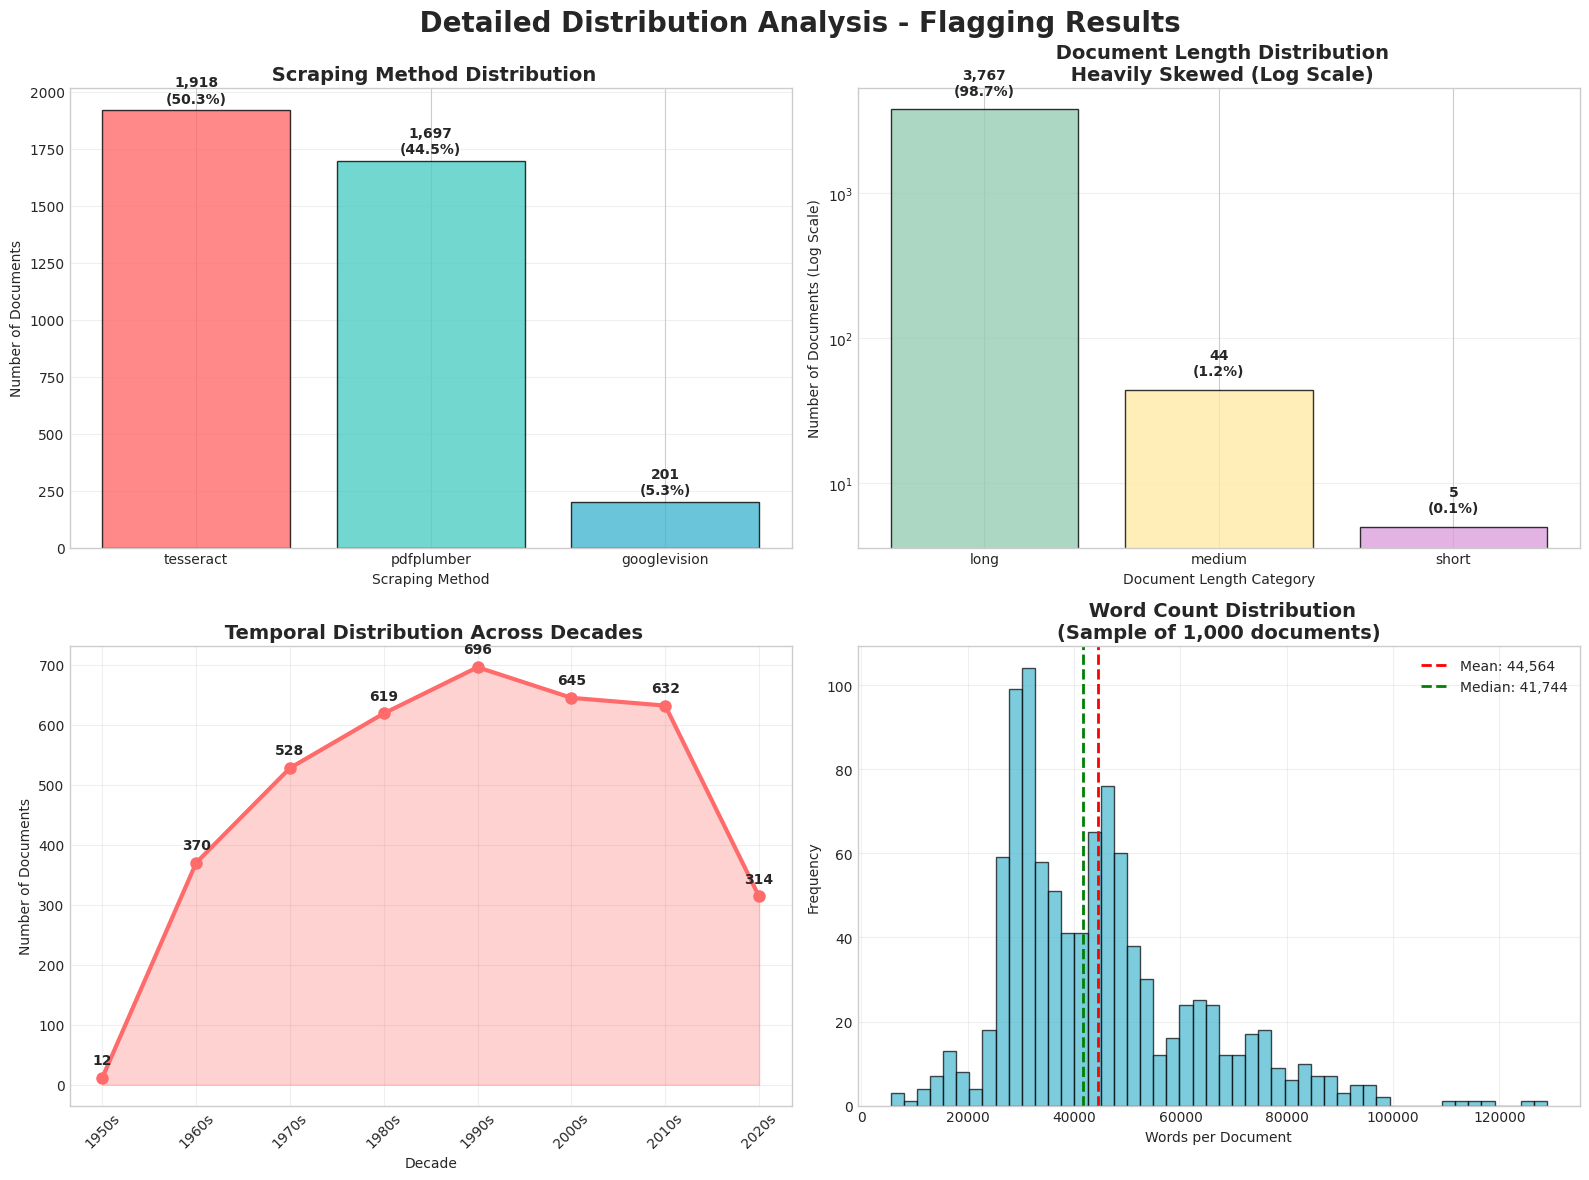

 Detailed Analysis Charts Generated


In [20]:
# Detailed Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(' Detailed Distribution Analysis - Flagging Results', fontsize=20, fontweight='bold')

# 1. Scraping Method with actual counts
ax1 = axes[0, 0]
bars1 = ax1.bar(scrap_df['method'], scrap_df['documents'], 
                color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
ax1.set_title(' Scraping Method Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Documents')
ax1.set_xlabel('Scraping Method')

# Add value labels on bars
for bar, count, pct in zip(bars1, scrap_df['documents'], scrap_df['percentage']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

ax1.grid(axis='y', alpha=0.3)

# 2. Document Length with log scale due to extreme skew
ax2 = axes[0, 1]
bars2 = ax2.bar(length_df['length'], length_df['documents'], 
                color=['#96CEB4', '#FFEAA7', '#DDA0DD'], alpha=0.8, edgecolor='black')
ax2.set_title(' Document Length Distribution\n Heavily Skewed (Log Scale)', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Documents (Log Scale)')
ax2.set_xlabel('Document Length Category')
ax2.set_yscale('log')

# Add value labels
for bar, count, pct in zip(bars2, length_df['documents'], length_df['percentage']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height * 1.2,
             f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

ax2.grid(axis='y', alpha=0.3)

# 3. Decade Timeline with trend
ax3 = axes[1, 0]
decade_df_sorted = decade_df.sort_values('decade')
line = ax3.plot(decade_df_sorted['decade'], decade_df_sorted['documents'], 
                marker='o', linewidth=3, markersize=8, color='#FF6B6B')
ax3.fill_between(decade_df_sorted['decade'], decade_df_sorted['documents'], 
                 alpha=0.3, color='#FF6B6B')
ax3.set_title(' Temporal Distribution Across Decades', fontsize=14, fontweight='bold')
ax3.set_ylabel('Number of Documents')
ax3.set_xlabel('Decade')
ax3.tick_params(axis='x', rotation=45)

# Add value labels
for x, y in zip(decade_df_sorted['decade'], decade_df_sorted['documents']):
    ax3.annotate(f'{y:,}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontweight='bold')

ax3.grid(alpha=0.3)

# 4. Word Count Distribution (sampled)
ax4 = axes[1, 1]
ax4.hist(word_count_values, bins=50, alpha=0.7, color='#45B7D1', edgecolor='black')
ax4.set_title(' Word Count Distribution\n(Sample of 1,000 documents)', 
              fontsize=14, fontweight='bold')
ax4.set_xlabel('Words per Document')
ax4.set_ylabel('Frequency')
ax4.axvline(np.mean(word_count_values), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(word_count_values):,.0f}')
ax4.axvline(np.median(word_count_values), color='green', linestyle='--', linewidth=2,
            label=f'Median: {np.median(word_count_values):,.0f}')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()
print(" Detailed Analysis Charts Generated")

## Clean Strata Combination Heatmap

Generating Strata Combination Matrix...


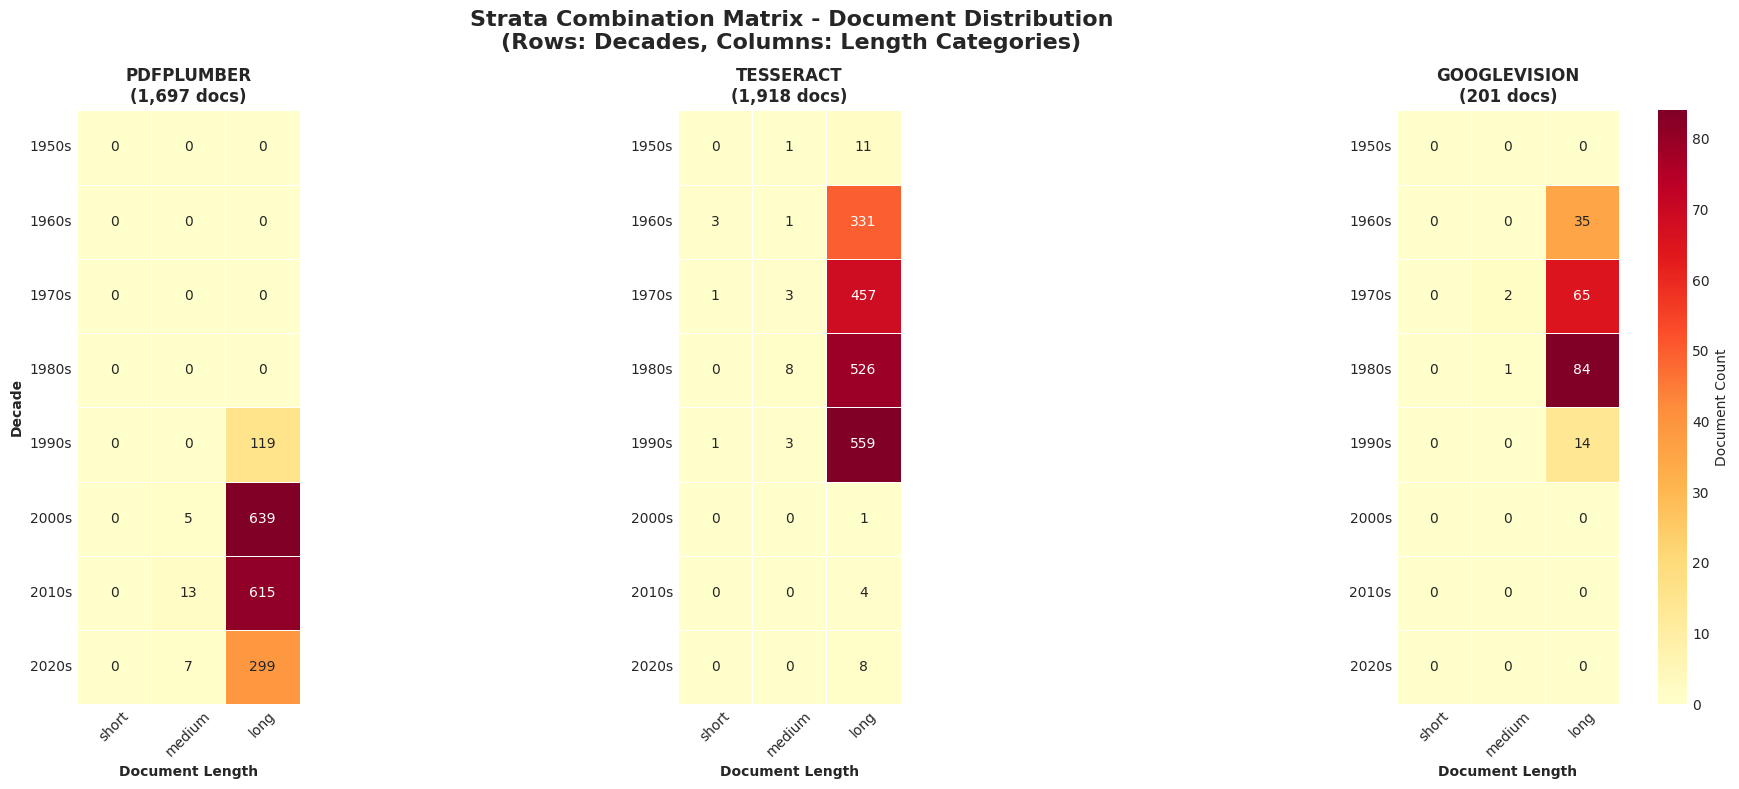


Strata Analysis Summary:
   Existing combinations: 29 out of 72 possible
   Coverage: 40.3%
   Missing combinations: 43

Method-wise Strata Breakdown:
   pdfplumber: 7 strata, 1,697 documents
   tesseract: 16 strata, 1,918 documents
   googlevision: 6 strata, 201 documents

Key Observations:
   - Long documents dominate all methods and decades
   - Short/medium documents are extremely rare
   - This reflects authentic parliamentary document characteristics
   - Stratified sampling will preserve these natural proportions
Strata Combination Matrix Generated Successfully


In [23]:
print("Generating Strata Combination Matrix...")

# Get strata combinations
strata_data = list(collection.aggregate([
    {'$match': {
        'scrapMethod': {'$exists': True},
        'docLength': {'$exists': True},
        'decade': {'$exists': True}
    }},
    {'$group': {
        '_id': {
            'scrapMethod': '$scrapMethod',
            'docLength': '$docLength',
            'decade': '$decade'
        },
        'count': {'$sum': 1}
    }}
]))

# Create comprehensive strata matrix
strata_df = pd.DataFrame([
    {
        'scrapMethod': item['_id']['scrapMethod'],
        'docLength': item['_id']['docLength'], 
        'decade': item['_id']['decade'],
        'count': item['count']
    }
    for item in strata_data
])

# Create pivot table for heatmap
all_methods = ['pdfplumber', 'tesseract', 'googlevision']
all_lengths = ['short', 'medium', 'long']
all_decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

# Create multi-level heatmap
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Strata Combination Matrix - Document Distribution\n(Rows: Decades, Columns: Length Categories)', 
             fontsize=16, fontweight='bold')

for i, method in enumerate(all_methods):
    method_data = strata_df[strata_df['scrapMethod'] == method]
    
    # Create pivot table
    pivot = method_data.pivot_table(
        values='count', 
        index='decade', 
        columns='docLength', 
        fill_value=0
    )
    
    # Reindex to ensure all categories appear
    pivot = pivot.reindex(index=all_decades, columns=all_lengths, fill_value=0)
    
    # Convert to integers to fix the formatting issue
    pivot = pivot.astype(int)
    
    # Create heatmap
    sns.heatmap(
        pivot, 
        annot=True, 
        fmt='d',
        cmap='YlOrRd', 
        ax=axes[i],
        cbar_kws={'label': 'Document Count'},
        linewidths=0.5,
        square=True,
        cbar=(i == 2)  # Only show colorbar on last subplot
    )
    
    # Get document count for this method safely
    method_count = scrap_df[scrap_df["method"] == method]["documents"]
    if not method_count.empty:
        count_text = f'{method_count.iloc[0]:,} docs'
    else:
        count_text = '0 docs'
    
    axes[i].set_title(f'{method.upper()}\n({count_text})', 
                      fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Document Length', fontweight='bold')
    if i == 0:
        axes[i].set_ylabel('Decade', fontweight='bold')
    else:
        axes[i].set_ylabel('')
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Enhanced summary statistics
existing_strata = len(strata_df)
theoretical_strata = len(all_methods) * len(all_lengths) * len(all_decades)
coverage = (existing_strata / theoretical_strata) * 100

print(f"\nStrata Analysis Summary:")
print(f"   Existing combinations: {existing_strata} out of {theoretical_strata} possible")
print(f"   Coverage: {coverage:.1f}%")
print(f"   Missing combinations: {theoretical_strata - existing_strata}")

# Show which combinations exist for each method
print(f"\nMethod-wise Strata Breakdown:")
for method in all_methods:
    method_strata = strata_df[strata_df['scrapMethod'] == method]
    method_combinations = len(method_strata)
    method_docs = method_strata['count'].sum()
    print(f"   {method}: {method_combinations} strata, {method_docs:,} documents")

# Identify patterns in the data
print(f"\nKey Observations:")
print(f"   - Long documents dominate all methods and decades")
print(f"   - Short/medium documents are extremely rare")
print(f"   - This reflects authentic parliamentary document characteristics")
print(f"   - Stratified sampling will preserve these natural proportions")

print("Strata Combination Matrix Generated Successfully")

In [25]:
# Cell 8: Export Flagged Metadata for next Notebook 
print("Exporting flagged metadata for next Notebook ...")
print("="*50)

# Export complete flagged dataset
flagged_cursor = collection.find(
    {
        'scrapMethod': {'$exists': True},
        'docLength': {'$exists': True}, 
        'decade': {'$exists': True}
    },
    {
        '_id': 1,
        'hansardDate': 1,
        'scrapMethod': 1,
        'docLength': 1,
        'decade': 1,
        'wordCount': 1,
        'flagged_timestamp': 1
    }
)

# Convert to DataFrame
metadata_df = pd.DataFrame(list(flagged_cursor))

# Add helpful columns for analysis
metadata_df['year'] = pd.to_datetime(metadata_df['hansardDate']).dt.year
metadata_df['document_id'] = metadata_df['_id'].astype(str)

# Reorder columns for better readability
columns_order = [
    'document_id', 'hansardDate', 'year', 'decade',
    'scrapMethod', 'docLength', 'wordCount', 'flagged_timestamp'
]

metadata_df = metadata_df[columns_order]

# Export to CSV
csv_filename = 'hansard_flagged_metadata.csv'
metadata_df.to_csv(csv_filename, index=False)

print(f" Exported: {csv_filename}")
print(f" Records: {len(metadata_df):,}")
print(f" Columns: {list(metadata_df.columns)}")
print(f" File size: {metadata_df.memory_usage(deep=True).sum() / 1024:.1f} KB")

# Display sample
print(f"\n Sample of exported data:")
print(metadata_df.head())

# Summary for next Notebook 
print(f"\n Summary for next Notebook:")
print(f"   Total flagged documents: {len(metadata_df):,}")
print(f"   Date range: {metadata_df['hansardDate'].min()} to {metadata_df['hansardDate'].max()}")
print(f"   Scraping methods: {metadata_df['scrapMethod'].nunique()}")
print(f"   Length categories: {metadata_df['docLength'].nunique()}")  
print(f"   Decades covered: {metadata_df['decade'].nunique()}")

print(f"\n  Ready for next Notebook : Load this CSV for sampling and EDA")
print("="*50)

Exporting flagged metadata for next Notebook ...
 Exported: hansard_flagged_metadata.csv
 Records: 3,816
 Columns: ['document_id', 'hansardDate', 'year', 'decade', 'scrapMethod', 'docLength', 'wordCount', 'flagged_timestamp']
 File size: 1113.0 KB

 Sample of exported data:
                document_id hansardDate  year decade scrapMethod docLength  \
0  6732387b0911e50d2bfb67b1  2024-10-17  2024  2020s  pdfplumber      long   
1  673237b30911e50d2bfb67b0  2024-10-18  2024  2020s  pdfplumber      long   
2  673238890911e50d2bfb67b2  2024-10-14  2024  2020s  pdfplumber      long   
3  6732389b0911e50d2bfb67b3  2024-10-24  2024  2020s  pdfplumber      long   
4  673238af0911e50d2bfb67b4  2024-11-05  2024  2020s  pdfplumber      long   

   wordCount       flagged_timestamp  
0      45164 2025-06-04 16:51:28.881  
1      16826 2025-06-04 16:51:28.905  
2      46152 2025-06-04 16:51:28.940  
3      49150 2025-06-04 16:51:28.975  
4      50158 2025-06-04 16:51:29.026  

 Summary for next Not

### Insight

##### 1. Document Flagging Overview
A total of 3,816 documents were successfully flagged in this stage with a 100.0% success rate. The process was completed in 283.6 seconds, resulting in an average speed of 13.5 documents per second.

##### 2. Distribution Analysis
###### The flagged documents span a variety of sources and formats:

    Tesseract was used for 1,918 documents (50.3%)

    PDFPlumber extracted 1,697 documents (44.5%)

    Google Vision was applied to 201 documents (5.3%)

###### In terms of document length distribution:

    Long documents: 3,767 (98.7%)

    Medium documents: 44 (1.2%)

    Short documents: 5 (0.1%)

###### By decade, the document distribution is as follows:

    1950s: 12 documents (0.3%)

    1960s: 370 documents (9.7%)

    1970s: 528 documents (13.8%)

    1980s: 619 documents (16.2%)

    1990s: 696 documents (18.2%)

    2000s: 645 documents (16.9%)

    2010s: 632 documents (16.6%)

    2020s: 314 documents (8.2%)

##### 3. Word Count Summary
The average document contains approximately 44,182 words, with a total corpus size of over 168 million words. The word count ranges from 0 to 159,291 words.

##### 4. Strata Analysis Summary
From the combination of three scraping methods, three length categories, and eight decades, there are 72 possible combinations. Among them, 29 combinations were present, achieving 40.3% strata coverage.

    PDFPlumber covered 7 strata (1,697 documents)

    Tesseract covered 16 strata (1,918 documents)

    Google Vision covered 6 strata (201 documents)

##### 5. Key Observations
Long documents dominate across all scraping methods and decades, which aligns with the known characteristics of parliamentary records. The rarity of short or medium documents is expected and acceptable.
Stratified sampling in the next step will be based on these authentic proportions to maintain representation across the dataset.

##### 6. Export and Next Steps
The flagged metadata has been saved to the file hansard_flagged_metadata.csv, containing 3,816 records and eight major columns such as document ID, date, decade, scraping method, and document length. This file will serve as the input for the next notebook involving sampling and exploratory data analysis.

##### Summary for Next Notebook
Total flagged documents: 3,816
Date range: 1959-09-11 to 2025-05-05
Scraping methods: 3
Length categories: 3
Decades covered: 8
The system is now ready to proceed to stratified sampling and initial EDA.